## Скрипт для скачивания OSISAF

In [7]:
import ftplib
import os
from pathlib import Path
import pandas as pd
from datetime import datetime

#ice_conc_nh_ease2-250_icdr-v3p0_202502071200.nc
def name_format(time: str, archive=True):
    #return f'ice_conc_nh_ease2-250_cdr-v3p1_{time}1200.nc'
    return f'ice_conc_nh_ease2-250_icdr-v3p0_{time}1200.nc'

def download(folder_to_save, file_name, ftp, silent=False):
    os.makedirs(folder_to_save, exist_ok=True)
    file_path = Path(folder_to_save, file_name)
    
    if file_path.exists():
        if not silent:
            print(f'{file_name} already exists')
        return True
            
    try:
        with open(file_path, 'wb') as f:
            ftp.retrbinary(f'RETR {file_name}', f.write)
        if not silent:
            print(f'Downloaded: {file_name}')
        return True
    except Exception as e:
        if not silent:
            print(f'Error downloading {file_name}: {e}')
        if file_path.exists():
            file_path.unlink()
        return False

def download_pack(folder_to_save, start_day, end_day):
    # Проверяем, что даты не в будущем
    today = datetime.today().strftime('%Y%m%d')
    if end_day > today:
        print(f"Warning: End date {end_day} is in the future. Adjusting to today {today}")
        end_day = today
    
    dates = pd.date_range(start_day, end_day, freq='1D')
    remote_dir = 'reprocessed/ice/conc-cont-reproc/v3p0'
    
    # Создаем одно подключение для всех файлов
    with ftplib.FTP('osisaf.met.no') as ftp:
        ftp.login()
        print("Connected to FTP server")
        
        # Создаем словарь для кэширования проверенных директорий
        valid_dirs = {}
        
        for date in dates:
            year = date.strftime('%Y')
            month = date.strftime('%m')
            date_str = date.strftime('%Y%m%d')
            file_name = name_format(date_str)
            
            # Проверяем существование файла локально
            local_path = Path(folder_to_save, file_name)
            if local_path.exists():
                print(f'Skipping existing file: {file_name}')
                continue
                
            # Формируем путь на сервере
            remote_path = f"{remote_dir}/{year}/{month}"
            
            # Проверяем, была ли директория уже проверена
            if remote_path in valid_dirs:
                if valid_dirs[remote_path] is False:
                    print(f"Skipping known invalid directory: {remote_path}")
                    continue
            else:
                # Проверяем существование директории
                try:
                    # Используем команду CWD для проверки существования директории
                    ftp.cwd(remote_path)
                    valid_dirs[remote_path] = True
                    print(f"Directory valid: {remote_path}")
                except ftplib.error_perm as e:
                    print(f"Directory not found: {remote_path} ({str(e)})")
                    valid_dirs[remote_path] = False
                    continue
            
            try:
                # Получаем список файлов в директории
                file_list = ftp.nlst()
                if file_name not in file_list:
                    print(f"File not found on server: {file_name}")
                    continue
                
                # Скачиваем файл
                if download(folder_to_save, file_name, ftp, silent=False):
                    print(f"Successfully downloaded: {file_name}")
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")
                continue

# Пример вызова с актуальными датами
folder_to_save = 'osisaf_data'
download_pack(folder_to_save, '20250201', '20250205') 

Connected to FTP server
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502011200.nc
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502021200.nc
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502031200.nc
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502041200.nc
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502051200.nc


## Скрипт для скачивания MASIE 

In [8]:
## import ftplib
import os
from pathlib import Path
import pandas as pd
from datetime import datetime, date

def day_of_year(year, month, day):
    date_obj = date(year, month, day)
    return '%03d' % date_obj.timetuple().tm_yday
    
#masie_all_r00_v01_2025001_4km.nc
def masie_name_format(date_str: str):
    #return f'masie_4km_ice_r00_v01_{date_str}.nc'
    return f'masie_all_r00_v01_{date_str}_1km.nc'


def download(folder_to_save, file_name, ftp, silent=False):
    os.makedirs(folder_to_save, exist_ok=True)
    file_path = Path(folder_to_save, file_name)
    
    if file_path.exists():
        if not silent:
            print(f'{file_name} already exists')
        return True
            
    try:
        with open(file_path, 'wb') as f:
            ftp.retrbinary(f'RETR {file_name}', f.write)
        if not silent:
            print(f'Downloaded: {file_name}')
        return True
    except Exception as e:
        if not silent:
            print(f'Error downloading {file_name}: {e}')
        if file_path.exists():
            file_path.unlink()
        return False

def download_masie(folder_to_save, start_day, end_day):
    today = datetime.today().strftime('%Y%m%d')
    if end_day > today:
        print(f"Adjusting end date to today ({today})")
        end_day = today
    
    dates = pd.date_range(start_day, end_day, freq='1D')
    base_dir = '/DATASETS/NOAA/G02186/netcdf/1km'
    
    with ftplib.FTP('sidads.colorado.edu') as ftp:
        ftp.login()  # Анонимный вход
        print("Connected to NSIDC FTP server")
        
        valid_dirs_cache = {}
        
        for date in dates:
            
            year = date.strftime('%Y')
            month = date.strftime('%m')
            date_str = date.strftime('%Y%m%d')
            
            y, m, d = int(date_str[0:4]), int(date_str[4:6]), int(date_str[6:8]) 
            day_number = day_of_year(y, m, d)
            
            file_name = masie_name_format(f"{year}{day_number}")
            local_path = Path(folder_to_save, file_name)
            
            # Пропустить существующие файлы
            if local_path.exists():
                print(f'Skipping: {file_name}')
                continue
                
            # Формирование пути на сервере
            remote_dir = f"{base_dir}/{year}" #{day_number}" #/{month}"
            
            # Проверка директории в кэше
            if remote_dir in valid_dirs_cache:
                if not valid_dirs_cache[remote_dir]:
                    continue
            else:
                try:
                    ftp.cwd(remote_dir)
                    valid_dirs_cache[remote_dir] = True
                    print(f"Directory accessible: {remote_dir}")
                except ftplib.error_perm:
                    print(f"Directory not found: {remote_dir}")
                    valid_dirs_cache[remote_dir] = False
                    continue
            
            # Проверка наличия файла
            try:
                if file_name not in ftp.nlst():
                    print(f"File not available: {file_name}")
                    continue
                    
                download(folder_to_save, file_name, ftp)
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")

# Пример использования
folder_to_save = 'masie_data'
download_masie(folder_to_save, '20250201', '20250205')

Connected to NSIDC FTP server
Skipping: masie_all_r00_v01_2025032_1km.nc
Skipping: masie_all_r00_v01_2025033_1km.nc
Skipping: masie_all_r00_v01_2025034_1km.nc
Skipping: masie_all_r00_v01_2025035_1km.nc
Skipping: masie_all_r00_v01_2025036_1km.nc


## Plot files

Рисовать буду за 03.02.2025
Снимки:
1. osisaf
2. masie
3. Geotiff (оптика)
4. Гибридный снимок

tutor plot: https://medium.com/@Manjar-Alam/clipping-and-visualizing-netcdf-data-using-python-84dfbbbce0a5

In [9]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd

In [10]:
ds_osisaf = xr.open_dataset('/home/voland/dev/projects/nss_lab/osisaf_masie_qgis/osisaf_data/ice_conc_nh_ease2-250_icdr-v3p0_202502031200.nc')

In [11]:
ds_masie = xr.open_dataset('/home/voland/dev/projects/nss_lab/osisaf_masie_qgis/masie_data/masie_all_r00_v01_2025034_1km.nc')

In [13]:
ds_masie

<xarray.Dataset> Size: 2GB
Dimensions:              (time: 1, x: 24576, y: 24576)
Coordinates:
  * time                 (time) datetime64[ns] 8B 2025-02-03
  * x                    (x) float64 197kB -1.229e+07 -1.229e+07 ... 1.229e+07
    y                    (x) float64 197kB ...
Data variables:
    polar_stereographic  |S1 1B ...
    sea_ice_extent       (time, y, x) float32 2GB ...
Attributes: (12/52)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      Multisensor Analyzed Sea Ice Extent - Norther...
    creator_name:               National Snow and Ice Data Center
    creator_email:              nsidc@nsidc.org
    creator_url:                https://nsidc.org/
    institution:                National Snow and Ice Data Center
    ...                         ...
    date_created:               2025-02-04T20:01:35Z
    history:                    04 February 2025 20:01Z: NetCDF file generate...
    time_coverage_start:        2025-02-03T00:00:00Z
    time_coverage_end:          2025-02-03T23:59:59Z
    geospatial_bounds_crs:      PROJCS["Stereographic_North_Pole",GEOGCS["WGS...
    geospatial_bounds:          POLYGON ((12288000.0000000000000000 -12288000...

In [14]:
ds_masie['sea_ice_extent'].values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(1, 24576, 24576), dtype=float32)

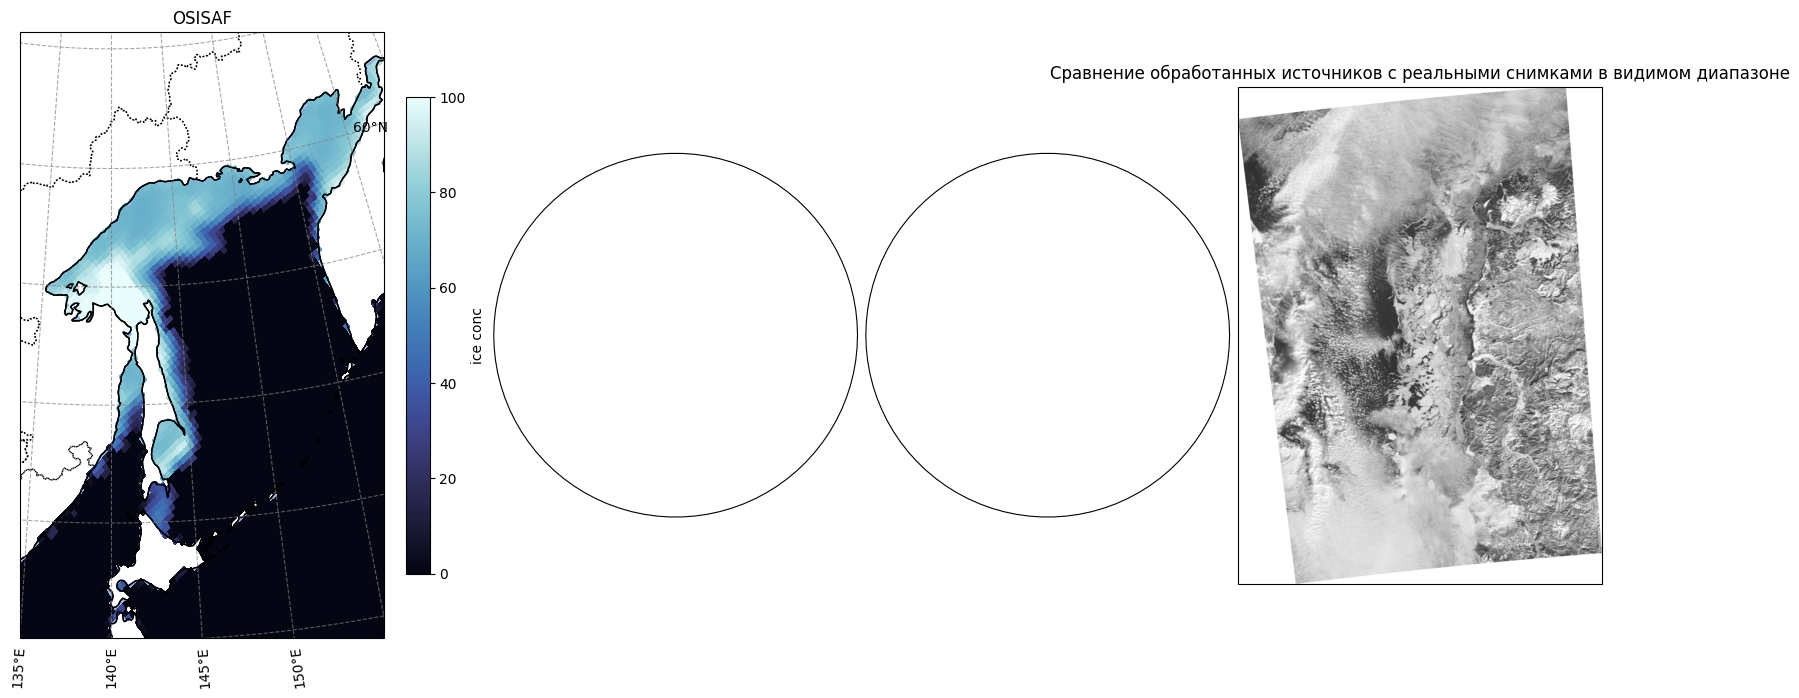

In [16]:
#fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.Stereographic(central_latitude=50, central_longitude=140)})
import cmocean as cm
import rioxarray as rxr


# Создаем фигуру с разными проекциями для последнего subplot
fig = plt.figure(figsize=(16, 12), layout="constrained")

# Первые три оси - Stereographic
ax0 = fig.add_subplot(1, 4, 1, projection=ccrs.Stereographic(central_latitude=50, central_longitude=140))
ax1 = fig.add_subplot(1, 4, 2, projection=ccrs.Stereographic(central_latitude=50, central_longitude=140))
ax2 = fig.add_subplot(1, 4, 3, projection=ccrs.Stereographic(central_latitude=50, central_longitude=140))

# Четвертая ось - NorthPolarStereo
ax3 = fig.add_subplot(1, 4, 4, projection=ccrs.NorthPolarStereo(central_longitude=-45))

axs = [ax0, ax1, ax2, ax3]

axs[0].coastlines()
axs[0].add_feature(cfeature.OCEAN)
axs[0].add_feature(cfeature.COASTLINE)
axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].add_feature(cfeature.STATES, linestyle=':')

# Add gridlines with labels
gridlines = axs[0].gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
gridlines.top_labels = False
gridlines.right_labels = False
gridlines.left_labels = True
gridlines.bottom_labels = True

# Adjust the padding and font size of the labels
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

# ========================
# 1. Plot OSISAF
# ========================

mesh_osisaf = axs[0].pcolormesh(
    ds_osisaf['lon'].values, 
    ds_osisaf['lat'].values, 
    ds_osisaf['ice_conc'].values[0,:,:], 
    cmap=cm.cm.ice, 
    transform=ccrs.PlateCarree()
)

# Добавление цветовой шкалы
cbar = plt.colorbar(mesh_osisaf, ax=axs[0], orientation='vertical', pad=0.05, shrink=0.4)
cbar.set_label('ice conc')

axs[0].set_extent((135, 155, 40, 65), crs=ccrs.PlateCarree())
axs[0].set_title('OSISAF')

# ========================
# 2. Plot MASIE
# ========================

'''
mesh_masie = axs[1].pcolormesh(
    ds_masie['lon'].values, 
    ds_masie['lat'].values, 
    ds_masie['ice_conc'].values[0,:,:], 
    cmap=cm.cm.ice, 
    transform=ccrs.PlateCarree()
)

# Добавление цветовой шкалы
cbar = plt.colorbar(mesh_masie, ax=axs[1], orientation='vertical', pad=0.05, shrink=0.4)
cbar.set_label('ice conc')

axs[1].set_extent((135, 155, 40, 65), crs=ccrs.PlateCarree())
axs[1].set_title('MASIE')
'''

# ========================
# 3. Plot satellite images
# ========================

sar_file = '/home/voland/dev/projects/nss_lab/osisaf_masie_qgis/snapshot-2025-02-03T00_00_00Z.tif'
sar_da = rxr.open_rasterio(sar_file).squeeze()

polar_crs = ccrs.NorthPolarStereo(central_longitude=-45)  # Полярная стереографическая проекция
sar_proj = sar_da.rio.reproject(polar_crs)

# === Построение карты ===
sar_img = sar_da.values
sar_img = sar_proj[0, :, :].values if sar_proj.ndim == 3 else sar_proj.values

axs[3].imshow(
    sar_img,
    extent=[sar_proj.x.min().item(), sar_proj.x.max().item(), sar_proj.y.min().item(), sar_proj.y.max().item()],
    cmap='gray',
    origin='upper',
    zorder=1,
    alpha=0.9
)

axs[3].set_title('GeoTiff')
# Заголовок
plt.title('Сравнение обработанных источников с реальными снимками в видимом диапазоне')

plt.show()